### Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os
import tqdm
import glob
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import RandomRotation, RandomZoom
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import applications
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam


from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, AUC,Recall
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet121
import copy
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import DenseNet121, ResNet50
from tensorflow.keras.utils import image_dataset_from_directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install git+https://github.com/jfilter/split-folders.git


  Cloning https://github.com/jfilter/split-folders.git to /tmp/pip-req-build-sk1ns3eb
  Running command git clone --filter=blob:none --quiet https://github.com/jfilter/split-folders.git /tmp/pip-req-build-sk1ns3eb
  Resolved https://github.com/jfilter/split-folders.git to commit c566dbd56a1097e1ddba2de5dfb93bd67eade54f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for split_folders: filename=split_folders-0.5.1-py3-none-any.whl size=8400 sha256=2f6facb60a29342f59af07a8d7abf1e3448e214ffca4bdd07c17de34c1bb2d18
  Stored in directory: /tmp/pip-ephem-wheel-cache-_ghlo8iw/wheels/0c/da/06/fcebe493adfe604ee9a1d4511e3932a6e63a044edb7a10dec8
Successfully built split_folders


In [ ]:
import splitfolders

# Set the path of the directory containing the original images
input_folder = '/content/drive/MyDrive/Axial'

# Set the base directory for the split images
output_folder = '/content/drive/MyDrive/Axial_Resnet_split'

# Set the ratio of images for each split
train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2

# Use the splitfolders library to split the images into train-validation-test sets
splitfolders.ratio(input_folder, output_folder, seed=42,
                   ratio=(train_ratio,
                          validation_ratio,
                          test_ratio))


Copying files: 4323 files [22:56,  3.14 files/s]


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 16
IMG_SIZE = (128, 128)
SEED = 1345

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        )

validation_datagen = ImageDataGenerator(rescale=1./255)


test_datagen = ImageDataGenerator(rescale=1./255)

# Define directories for train, validation, and test sets
train_dir = '/content/drive/MyDrive/Axial_Resnet_split/train'
validation_dir = '/content/drive/MyDrive/Axial_Resnet_split/val'
test_dir = '/content/drive/MyDrive/Axial_Resnet_split/test'

# Define generators for train and validation sets using flow_from_directory
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(128, 128),
        shuffle=True,
        seed = SEED,
        batch_size=64,
        class_mode ='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(128, 128),
        seed = SEED,
        shuffle=True,
        batch_size=64,
        class_mode ='categorical')

# Define generator for test set using flow_from_directory
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(128, 128),
        shuffle=True,
        seed = SEED,
        batch_size =64,
        class_mode ='categorical')

epochs = 10

Found 2592 images belonging to 3 classes.
Found 863 images belonging to 3 classes.
Found 867 images belonging to 3 classes.


In [ ]:
# class_names = train_generator.class_names
# class_names

class_names = list(train_generator.class_indices.keys())
class_names



['AD', 'CI', 'CN']

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


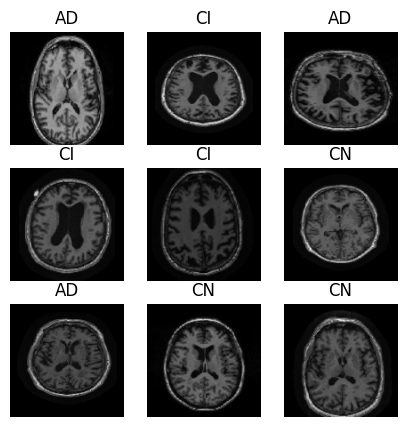

In [ ]:
plt.figure(figsize=(5, 5))
for images, labels in train_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
    break


## Data Augmentation

In [ ]:
from tensorflow.keras.models import Sequential


In [ ]:
#preprocessing for rotation and zoom
def data_augmentar():

    data_augmentation = Sequential()
    data_augmentation.add(RandomRotation(factor=(-0.15, 0.15)))
    data_augmentation.add(RandomZoom((-0.3, -0.1)))

    return data_augmentation


In [ ]:
data_augmentation = data_augmentar()
assert(data_augmentation.layers[0].name.startswith('random_rotation'))
assert(data_augmentation.layers[0].factor == (-0.15, 0.15))
assert(data_augmentation.layers[1].name.startswith('random_zoom'))
assert(data_augmentation.layers[1].height_factor == (-0.3, -0.1))


## Solving Imbalanced Data Problem

In [ ]:
## Calculate number of samples in each class.
input_folder = '/content/drive/MyDrive/Axial'
class_counts = dict()
for folder in class_names:
    class_counts[folder] = len(os.listdir(input_folder+'/'+folder))

class_counts


{'AD': 1124, 'CI': 1854, 'CN': 1345}

In [ ]:
models=[]
acc=[]


RESNET50

In [ ]:
from tensorflow.keras.applications import ResNet50

base_model_3 = ResNet50(input_shape=(128, 128, 3),
                        include_top=False,
                        weights="imagenet")

for layer in base_model_3.layers:
    layer.trainable = False




In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

prediction_layer = tf.keras.layers.Dense(3, activation='softmax')

model3 = tf.keras.Sequential([
    base_model_3,
    global_average_layer,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    prediction_layer
])


In [ ]:

model3.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy',
                        tf.keras.metrics.AUC(),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        ])

# Train your model
history = model3.fit(train_generator,
                     validation_data=validation_generator,
                     steps_per_epoch=len(train_generator),
                     epochs=20,
                     verbose=1)



Epoch 1/20
41/41 [==============================] - 30s 602ms/step - loss: 0.9962 - accuracy: 0.4884 - auc_2: 0.6835 - precision_2: 0.5858 - recall_2: 0.2396 - val_loss: 1.2822 - val_accuracy: 0.4287 - val_auc_2: 0.6057 - val_precision_2: 0.4287 - val_recall_2: 0.4287
Epoch 2/20
41/41 [==============================] - 24s 594ms/step - loss: 0.8326 - accuracy: 0.6022 - auc_2: 0.7985 - precision_2: 0.6742 - recall_2: 0.4742 - val_loss: 1.1426 - val_accuracy: 0.4287 - val_auc_2: 0.5943 - val_precision_2: 0.4287 - val_recall_2: 0.4287
Epoch 3/20
41/41 [==============================] - 26s 627ms/step - loss: 0.7237 - accuracy: 0.6775 - auc_2: 0.8563 - precision_2: 0.7390 - recall_2: 0.5910 - val_loss: 1.3551 - val_accuracy: 0.3627 - val_auc_2: 0.5539 - val_precision_2: 0.3556 - val_recall_2: 0.2966
Epoch 4/20
41/41 [==============================] - 26s 631ms/step - loss: 0.6142 - accuracy: 0.7473 - auc_2: 0.8977 - precision_2: 0.7870 - recall_2: 0.6941 - val_loss: 1.5765 - val_accuracy: 

In [ ]:
models.append("Resnet50")
model3.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 256)              

In [ ]:
result = model3.evaluate(train_generator, verbose=1)

print("Train Loss:", result[0])
print("Train Accuracy:", result[1])
print("Train AUC:", result[2])
print("Train Precision:", result[3])
print("Train Recall:", result[4])

'''for batch in train_generator:
    print(batch)
    break  # Print only the first batch for demonstration'''


41/41 [==============================] - 21s 512ms/step - loss: 0.1259 - accuracy: 0.9583 - auc_2: 0.9954 - precision_2: 0.9622 - recall_2: 0.9518
Train Loss: 0.12594501674175262
Train Accuracy: 0.9583333134651184
Train AUC: 0.9954174160957336
Train Precision: 0.9621685147285461
Train Recall: 0.9517747163772583


'for batch in train_generator:\n    print(batch)\n    break  # Print only the first batch for demonstration'

In [ ]:
filepath = '/content/weights.best.Resnet50.hdf5'
# Stop the model when accuracy is not improving
earlystopping = EarlyStopping(monitor = 'val_accuracy',
                              mode = 'max' ,
                              patience = 15,
                              verbose = 1)
# Finding point where accuracy differs more
checkpoint    = ModelCheckpoint(filepath,
                                monitor = 'val_accuracy',
                                mode='max',
                                save_best_only=True,
                                verbose = 1)


callback_list = [earlystopping, checkpoint]


In [ ]:
history3=model3.fit(train_generator,
                        validation_data=validation_generator,
                        steps_per_epoch=len(train_generator)//32,
                        epochs = 25,
                        verbose = 1,batch_size=32)


Epoch 1/25
1/1 [==============================] - 6s 6s/step - loss: 0.1755 - accuracy: 0.9219 - auc_2: 0.9918 - precision_2: 0.9219 - recall_2: 0.9219 - val_loss: 0.4685 - val_accuracy: 0.8644 - val_auc_2: 0.9594 - val_precision_2: 0.8687 - val_recall_2: 0.8586
Epoch 2/25
1/1 [==============================] - 4s 4s/step - loss: 0.1170 - accuracy: 0.9219 - auc_2: 0.9969 - precision_2: 0.9219 - recall_2: 0.9219 - val_loss: 0.4800 - val_accuracy: 0.8610 - val_auc_2: 0.9584 - val_precision_2: 0.8655 - val_recall_2: 0.8575
Epoch 3/25
1/1 [==============================] - 5s 5s/step - loss: 0.1524 - accuracy: 0.9219 - auc_2: 0.9941 - precision_2: 0.9516 - recall_2: 0.9219 - val_loss: 0.5051 - val_accuracy: 0.8482 - val_auc_2: 0.9576 - val_precision_2: 0.8556 - val_recall_2: 0.8447
Epoch 4/25
1/1 [==============================] - 5s 5s/step - loss: 0.1031 - accuracy: 0.9375 - auc_2: 0.9976 - precision_2: 0.9375 - recall_2: 0.9375 - val_loss: 0.5263 - val_accuracy: 0.8482 - val_auc_2: 0.95

In [ ]:
result = model3.evaluate(test_generator)
test_loss = result[0]
test_accuracy = result[1]
test_AUC = result[2]
test_pre = result[3]
test_rec = result[4]
print(f'Test Loss = {test_loss}')
print(f'Test Accuracy = {test_accuracy}')
print(f'Test AUC = {test_AUC}')
print(f'Test Precision = {test_pre}')
print(f'Test Recall = {test_rec}')
acc.append(test_accuracy*100)



14/14 [==============================] - 3s 229ms/step - loss: 0.4887 - accuracy: 0.8547 - auc_2: 0.9551 - precision_2: 0.8613 - recall_2: 0.8524
Test Loss = 0.488666296005249
Test Accuracy = 0.85467129945755
Test AUC = 0.9550825357437134
Test Precision = 0.8613053560256958
Test Recall = 0.8523644804954529


1/1 [==============================] - 0s 20ms/step
63.85 % chances are there that the image is CN
CN


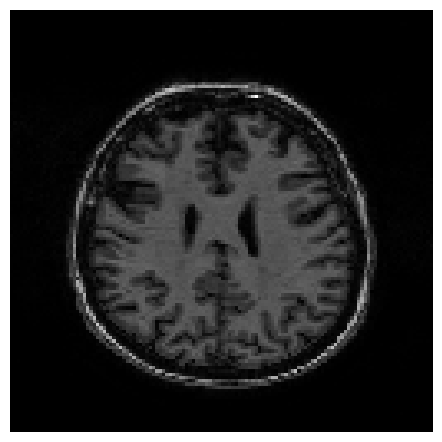

In [ ]:

dic = test_generator.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/Axial/CN/CN002_S_0413a084.png', target_size = (128,128,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = np.argmax(model3.predict(img),axis=1)
y_pred_prob = model3.predict(img)
y_pred = np.round(np.max(y_pred_prob)*100,2)

print(y_pred, '% chances are there that the image is',idc[answer[0]])
print(idc[answer[0]])

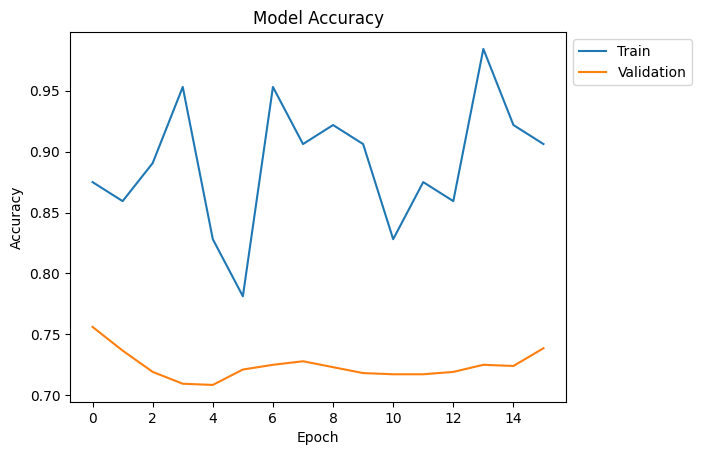

In [ ]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()


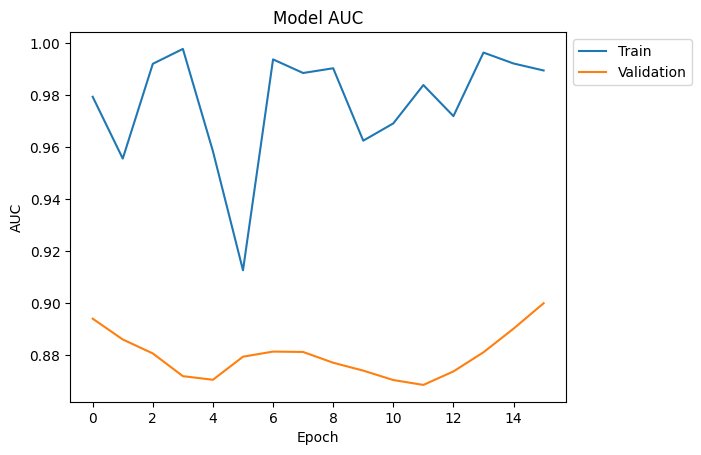

In [ ]:
plt.plot(history3.history['auc'])
plt.plot(history3.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

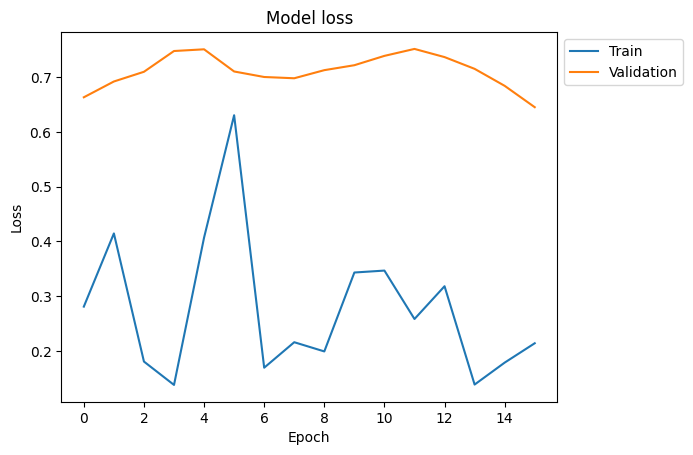

In [ ]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()


In [ ]:
def plot_confusion_matrix(true_lab,predict_lab,classes,path):
  matrix_confusion = tf.math.confusion_matrix(labels=true_lab, predictions=predicted_lab, num_classes=len(classes))
  ax = plt.subplot()
  sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(classes)
  ax.yaxis.set_ticklabels(classes)
  plt.savefig(f'{path}confusion_matrix.png')


In [ ]:
def dump_text(text,path):
  text_file = open(path, "w")
  text_file.write(text)
  text_file.close()


17/17 [==============================] - 5s 237ms/step


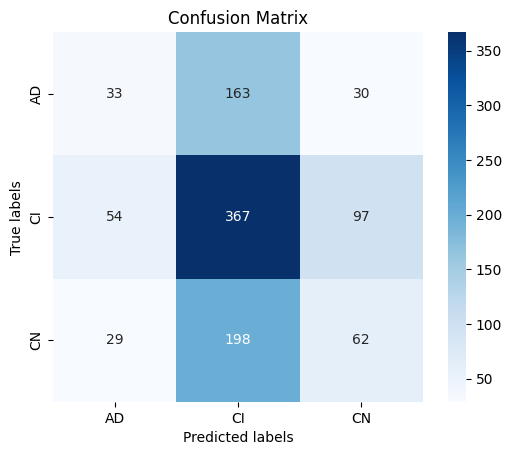

In [ ]:
#Confusion Matrix for vgg19

p = model3.predict(test_generator)
predicted_lab = p.argmax(axis=-1)
true_lab = test_generator.classes
plot_confusion_matrix(true_lab, predicted_lab, test_generator.class_indices.keys(),filepath)



## DenseNet121 not required

In [ ]:
base_model_4 = DenseNet121(input_shape=(128,128,3),
                         include_top=False,
                         weights="imagenet")

In [ ]:
for layer in base_model_4.layers:
    layer.trainable=False

In [ ]:

model=Sequential()
model.add(base_model_4)

model.add(Dropout(0.5))
model.add(Flatten()
)
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())

model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())

model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(512,kernel_initializer='he_uniform'))

model.add(Dense(4,activation='softmax'))

In [ ]:
models.append(model)
model.summary()

In [ ]:
model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy',
                        tf.keras.metrics.AUC(),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        ])


history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs = epochs,
                    verbose=1)


In [ ]:
models.append("DenseNet121")
model.summary()

In [ ]:
result = model.evaluate(train_generator)
train_loss = result[0]
train_accuracy = result[1]
train_AUC = result[2]
train_pre = result[3]
train_rec = result[4]
print(f'Train Loss = {train_loss}')
print(f'Train Accuracy = {train_accuracy}')
print(f'Train AUC = {train_AUC}')
print(f'Train Precision = {train_pre}')
print(f'Train Recall = {train_rec}')

In [ ]:
filepath = './DenseNet121_best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_accuracy',
                              mode = 'auto' ,
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath,
                                monitor = 'val_accuracy',
                                mode='auto',
                                save_best_only=True,
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
history4 = model.fit(train_generator,
                        validation_data=validation_generator,
                        steps_per_epoch=len(train_generator)//32,
                        epochs = 20,callbacks = callback_list,
                        verbose = 1,batch_size=16)

In [ ]:
result = model3.evaluate(test_generator)
test_loss = result[0]
test_accuracy = result[1]
test_AUC = result[2]
test_pre = result[3]
test_rec = result[4]
print(f'Test Loss = {test_loss}')
print(f'Test Accuracy = {test_accuracy}')
print(f'Test AUC = {test_AUC}')
print(f'Test Precision = {test_pre}')
print(f'Test Recall = {test_rec}')
acc.append(test_accuracy*100)

In [ ]:
dic = test_generator.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/MildDemented/00046ff7-0fae-4796-9a2b-2df47095bfe6.jpg', target_size = (128,128,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = np.argmax(model.predict(img),axis=1)
y_pred_prob = model.predict(img)
y_pred = np.round(np.max(y_pred_prob)*100,2)

print(y_pred, '% chances are there that the image is',idc[answer[0]])

In [ ]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
plt.plot(history4.history['auc'])
plt.plot(history4.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
def plot_confusion_matrix(true_lab,predict_lab,classes,path):
  matrix_confusion = tf.math.confusion_matrix(labels=true_lab, predictions=predicted_lab, num_classes=len(classes))
  ax = plt.subplot()
  sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(classes)
  ax.yaxis.set_ticklabels(classes)
  plt.savefig(f'{path}confusion_matrix.png')

In [ ]:
def dump_text(text,path):
  text_file = open(path, "w")
  text_file.write(text)
  text_file.close()

In [ ]:
#Confusion Matrix for densenet121

p = model.predict(test_generator)
predicted_lab = p.argmax(axis=-1)
true_lab =test_generator.classes
plot_confusion_matrix(true_lab, predicted_lab, test_generator.class_indices.keys(),filepath)
